In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/scripts"))
import auxiliar as aux
import geometry as geom

# Configuration and paths

In [2]:
# Source specifications
source_name = "crab"

# Run numbers
runs = [6172, 3954, 4028, 6853, 6194]

create_run_night_dict = False

sampling_number = 7

In [3]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/dl2_production/"
# Objects path
dir_objects = root + "objects"
# Root path to datachecks
dcheck_root = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_"
# Config filename for launching the bash script
jobconfig_fname = "jobconfig.txt"

# Creating the directories in case they don't exist
for path in [dir_objects]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

# Datacheck run-night information extraction

In [4]:
if create_run_night_dict:
    
    dchecks = glob.glob(dcheck_root + "*.h5")
    
    dict_night_run = {}
    for i, dcheck in enumerate(dchecks):
        if i % 23 == 0:
            print(f"{i}/{len(dchecks)}")

        night = dcheck.split("_")[-1].split(".")[0]

        runs = np.unique(pd.read_hdf(dcheck, key="runsummary")["runnumber"])
        for run in runs:
            dict_night_run[run] = night

    # Saving the objects
    with open(dir_objects + "/run_night_dictionary.pkl", 'wb') as f:
        pickle.dump(dict_night_run, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(dir_objects + "/run_night_dictionary.pkl", 'rb') as f:
        dict_night_run = pickle.load(f)    

# Read datacheck light yield data

In [5]:
light_scalings = []
run_indexes    = []
runss  = []
sruns = []

for i, run in enumerate(runs):
    
    dcheck = dcheck_root + dict_night_run[run] + ".h5"

    tab = pd.read_hdf(dcheck, key="cosmics_intensity_spectrum").query(f"runnumber == {run}")
    
    for srun in np.array(tab["subrun"]):
        
        light_scaling_factor = 1 / tab.iloc[srun]["light_yield"]
        
        run_indexes.append(i)
        light_scalings.append(light_scaling_factor)
        runss.append(run)
        sruns.append(srun)   

# Filtering rates

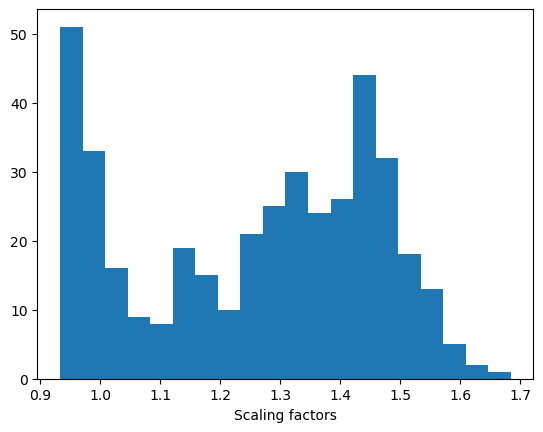

In [6]:
counts, bins, _ = plt.hist(light_scalings, 20)
plt.xlabel("Scaling factors")
plt.show()

In [7]:
for _ in [1,2,3,4]:
    N = 3
    for i, b in enumerate(bins[:-1]):

        n = 0
        for j, scale in enumerate(light_scalings):

            if scale <= bins[i+1] and scale >= bins[i]:
                n = n + 1
                if n > N:
                    run_indexes.pop(j)
                    light_scalings.pop(j)
                    runss.pop(j)
                    sruns.pop(j)

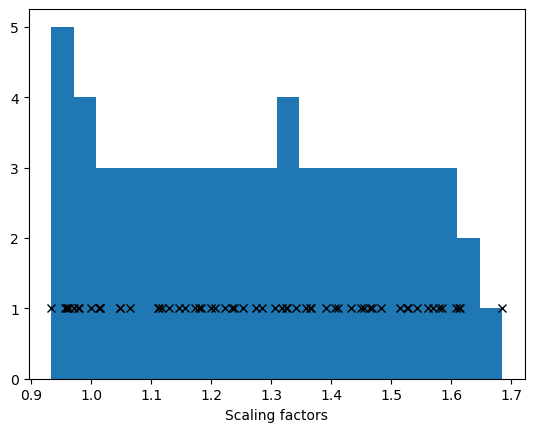

In [8]:
counts, bins, _ = plt.hist(light_scalings, 20)
plt.plot(light_scalings, np.repeat(1, len(light_scalings)), "xk")
plt.xlabel("Scaling factors")
plt.show()

## Write it to a job summary file

In [9]:
file = open(jobconfig_fname, "w")
file.write("# Job configuration file\n# RUN_INDEX-RUN-SUBRUN-light yields scaling factors applied")

for i in range(len(run_indexes)):
        
    file.write(f"\n{0}-{runss[i]}-{sruns[i]}-{1.}")
    file.write(f",{light_scalings[i]}")

    for scale in np.linspace(light_scalings[i] - 0.4, light_scalings[i] + 0.15, sampling_number):
        file.write(f",{scale}")

file.close()  